In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# fancy imports
from scipy.optimize import minimize
from linearmodels.iv import IV2SLS
from functools import partial
from scipy.stats import norm

np.random.seed(123)

# Generalized method of moments

This notebook accompanies the lecture slides on the *Generalized method of moments*. 

* **Example 1** We study a simulated sample that can be estimated by ordinary least squares regression to illustrate its unifying principles.

* **Example 2** We study a simulated sample that can be estimated by instrumental variables methods.

In [2]:
def get_sample_1(num_agents, beta, seed=123):

    random_sampling = partial(np.random.normal, size=num_agents)
    np.random.seed(seed)

    X = random_sampling(scale=10)
    eps = random_sampling()

    Y = 1 + beta * X + eps

    index = pd.Index(range(num_agents), name="Identifier")
    columns = ["Y", "X"]
    df = pd.DataFrame(np.vstack((Y, X)).T, columns=columns, index=index)
    return df


def get_moments(df, beta):
    residuals = df["Y"] - (1 + beta * df["X"])
    moments = df["X"] * residuals
    return np.mean(moments)

## How does the empirical moment at the truth change as we increase the sample size?

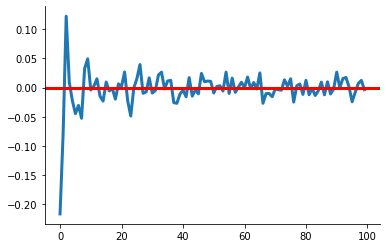

In [3]:
beta, rslt = 0.2, list()

# We iterate over different sample sizes.
grid = np.linspace(100, 1000000, num=100, dtype=int)
for num_agents in grid:

    # We simulate a sample and compute the residuals a
    moment = get_moments(get_sample_1(num_agents, beta), beta)
    rslt.append(moment)

ax = plt.plot(rslt)
plt.axhline(y=0, color="r")

## How does a GMM estimation look like?

In [4]:
df = get_sample_1(num_agents=10000, beta=7)


def criterion_function_gmm(beta, df):
    moments = get_moments(df, beta)
    # Where is weighting matrix?
    return np.square(np.mean(moments))


rslt = minimize(criterion_function_gmm, 0.0, args=(df,), method="BFGS")
rslt

      fun: 5.510400060594885e-13
 hess_inv: array([[5.03694767e-05]])
      jac: array([-5.57720085e-11])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([7.00055904])

## How does an OLS estimation look like?

In [5]:
rslt = smf.ols("Y ~ X", data=df).fit()
print("OLS Estimate ", "{:5.7f}".format(rslt.params[1]))

OLS Estimate  7.0005490


## How does a standard MLE estimation look like?

In [6]:
def get_residuals(df, beta):
    residuals = df["Y"] - (1 + beta * df["X"])
    return residuals


def criterion_function_mle(beta, df):
    residuals = get_residuals(df, beta)
    rslt = np.clip(np.log(norm.pdf(residuals)), -10e6, None)
    return -np.mean(rslt)


rslt = minimize(criterion_function_mle, 0.0, args=(df,), method="Powell")
rslt

/home/peisenha/local/anaconda3/envs/teaching-microeconometrics/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


   direc: array([[1.]])
     fun: 1.4215364807667554
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 2
  status: 0
 success: True
       x: array(7.00055905)

## Example 2

In [7]:
def get_sample_2(num_agents, beta, seed=123):

    # Setup of sample simulation
    random_sampling = partial(np.random.normal, size=num_agents)
    np.random.seed(seed)

    # Create canvas for data frame
    index = pd.Index(range(num_agents), name="Identifier")
    columns = ["Y", "X", "Z1", "Z2"]
    df = pd.DataFrame(columns=columns, index=index)

    for label in ["Z1", "Z2"]:
        df[label] = random_sampling(scale=10)
    C = random_sampling(scale=10)

    df["X"] = C + df[["Z1", "Z2"]].sum(axis=1) + random_sampling()
    U = C + random_sampling()

    df["Y"] = 1 + beta * df["X"] + U

    return df


df = get_sample_2(num_agents=10000, beta=7)

## How does an OLS estimate look like?

In [8]:
rslt = smf.ols("Y ~ X", data=df).fit()
print("OLS Estimate ", "{:5.3f}".format(rslt.params[1]))

OLS Estimate  7.325


## How does an IV estimate look like?

In [9]:
rslt = IV2SLS.from_formula("Y ~ 1 + [X ~ Z1 + Z2]", df).fit()
print("IV Estimate ", "{:5.3f}".format(rslt.params[1]))

IV Estimate  6.985


## How does a GMM estimation look like?

In [10]:
def get_moments(df, beta):
    residuals = df["Y"] - (1 + beta * df["X"])

    moments = list()
    for label in ["Z1", "Z2"]:
        moments.append(np.mean(df[label] * residuals))

    return moments


def criterion_function_gmm(beta, df, weighing_matrix=np.identity(2)):
    moments = get_moments(df, beta)
    rslt = np.dot(np.dot(moments, weighing_matrix), moments)
    return rslt


rslt = minimize(criterion_function_gmm, 0.0, args=(df), method="Powell")
print("GMM Estimate ", "{:5.3f}".format(rslt.x))

GMM Estimate  6.985
